# Import Library

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer

# Problem

Predict which passengers survived

# Load Data

In [259]:
df_train_origin = pd.read_csv('datasets/train.csv')
df_test_origin = pd.read_csv('datasets/test.csv')
df_submission = pd.read_csv("datasets/gender_submission.csv", index_col="PassengerId")

# Make copies to keep originals
df_train = df_train_origin.copy()
df_test = df_test_origin.copy()

# Exploratory Data Analysis(EDA)

In [6]:
display(df_train_origin.info())
display(df_train_origin.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Pclass

**Hypothesis**

Paseengers in higher Pclass are more likely than in lower Pclass to survive.

In [7]:
pd.pivot_table(df_train_origin, values=['Survived'], index=['Pclass'], aggfunc=np.mean)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


<AxesSubplot:xlabel='Survived', ylabel='count'>

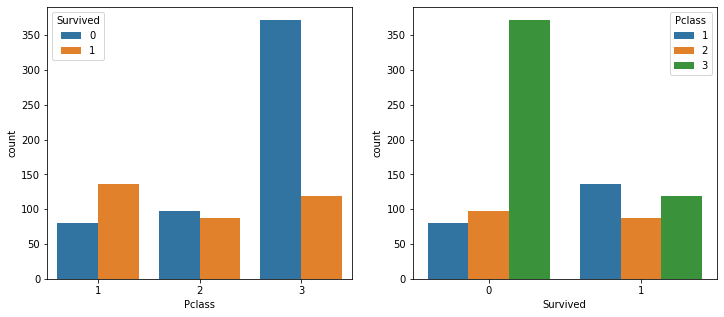

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x='Pclass', hue='Survived', data=df_train_origin, ax=ax[0])
sns.countplot(x='Survived', hue='Pclass', data=df_train_origin, ax=ax[1])

## Sex


**Hypothesis**

Female passengers are more likely than male passengers to survive.

In [13]:
pd.pivot_table(data=df_train_origin, values=['Survived'], index=['Sex'], aggfunc=np.mean)

,Survived
Sex,
female,0.742038
male,0.188908


<AxesSubplot:xlabel='Survived', ylabel='count'>

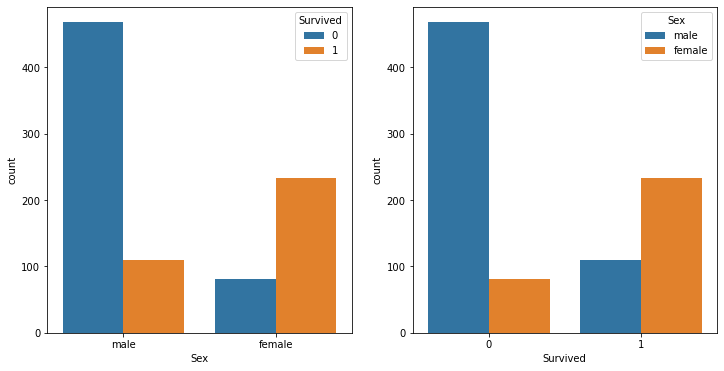

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(x='Sex', hue='Survived', data=df_train_origin, ax=ax[0])
sns.countplot(x='Survived', hue='Sex', data=df_train_origin, ax=ax[1])

## Age

**Hypothesis**

Passengers who are younger and elder are likely to survive. Age is continuous data so that it might be useful to make a category for age.

<AxesSubplot:xlabel='Age', ylabel='Count'>

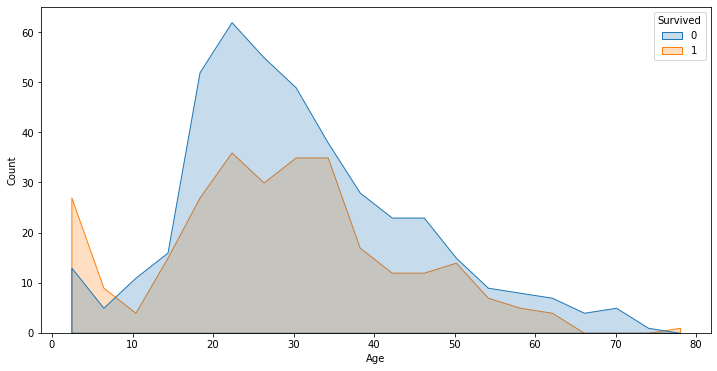

In [15]:
plt.figure(figsize=(12,6))
sns.histplot(x='Age', hue='Survived', data=df_train_origin, element='poly')

## SibSp

**Hypothesis**

Passengers who had one sibling or spouse are likely to survive.

<AxesSubplot:xlabel='Survived', ylabel='count'>

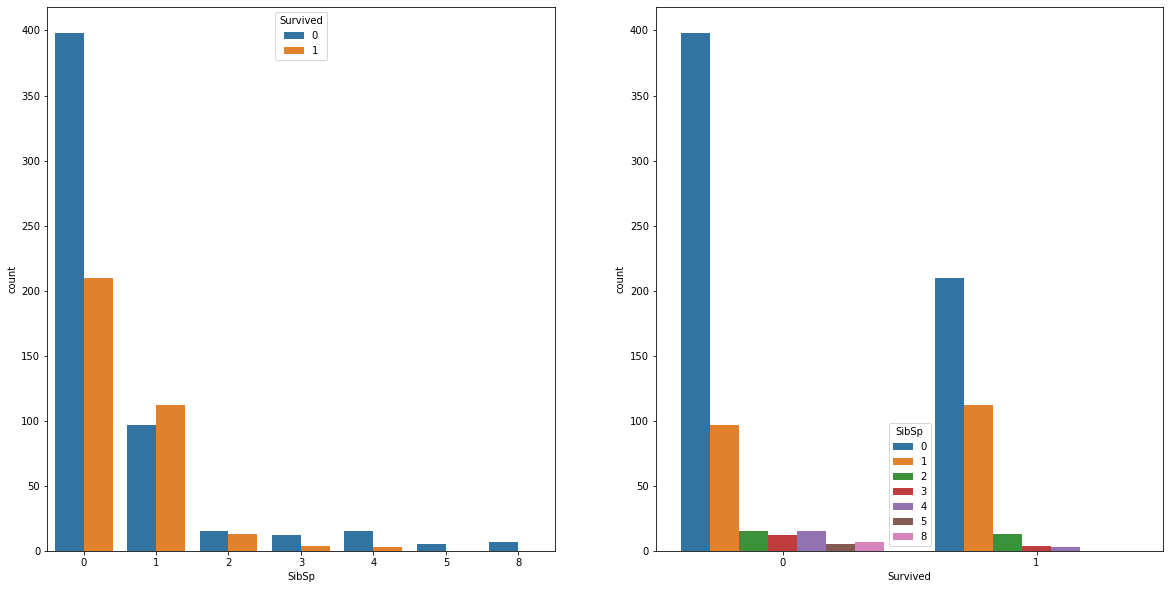

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
sns.countplot(x='SibSp', hue='Survived', data=df_train_origin, ax=ax[0])
sns.countplot(x='Survived', hue='SibSp', data=df_train_origin, ax=ax[1])

## Parch

**Hypothesis**

Passengers who had one parent or child are likely to survive.

<AxesSubplot:xlabel='Survived', ylabel='count'>

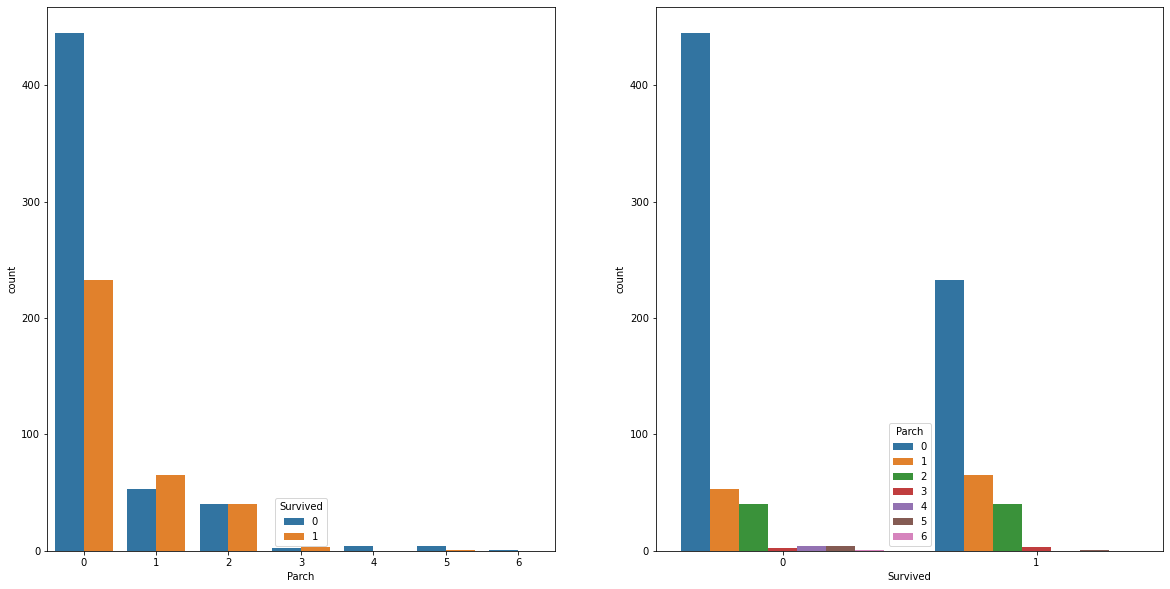

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
sns.countplot(x='Parch', hue='Survived', data=df_train_origin, ax=ax[0])
sns.countplot(x='Survived', hue='Parch', data=df_train_origin, ax=ax[1])

## Family Size(SibSp + Parch)

**Hypothesis**

Passengers who are single and have family member more than 3 are unlikely to survive. Passengers who have 1-3 family members are likely to survive. 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,3
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0


<AxesSubplot:xlabel='Family', ylabel='count'>

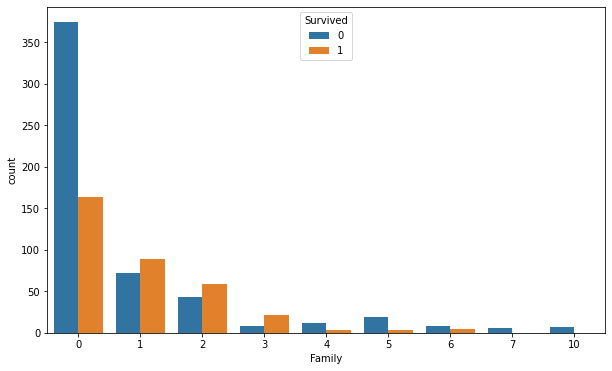

In [90]:
df_train_origin['Family'] = df_train_origin['SibSp'] + df_train_origin['Parch']
display(df_train_origin)

plt.figure(figsize=(10,6))
sns.countplot(data=df_train_origin, x='Family', hue='Survived')

## Ticket

**Hypothesis**

It seems hard to get insight and correlation from Ticket.

<AxesSubplot:xlabel='Ticket', ylabel='Count'>

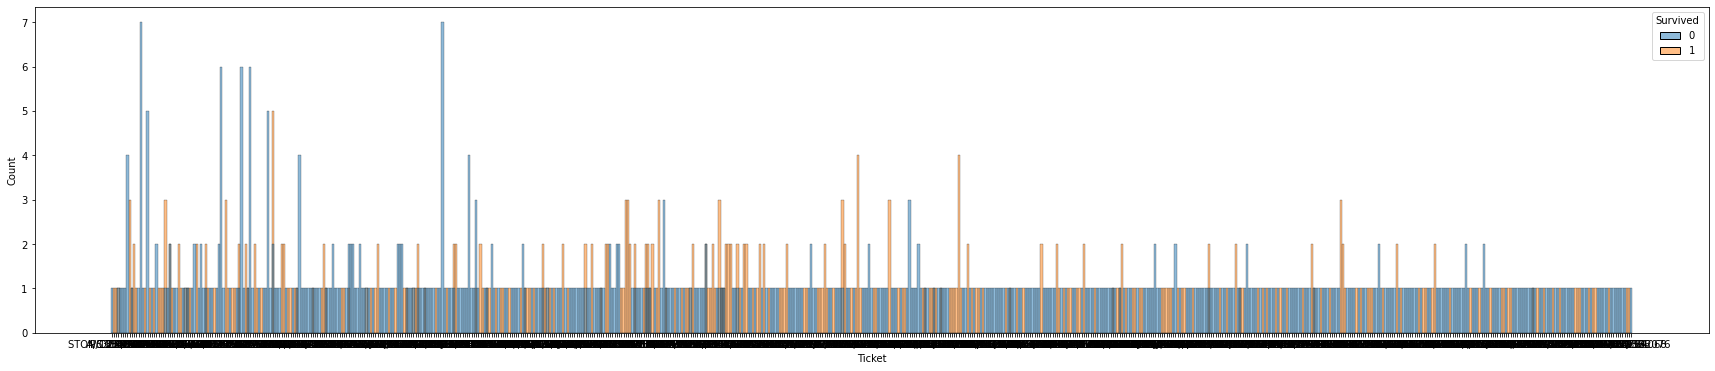

In [27]:
plt.figure(figsize=(30,6))
sns.histplot(x='Ticket', hue='Survived', data=df_train_origin, element='bars')
#sns.lmplot(x='Ticket', y='Age', hue='Survived', data=df_train_origin)

## Fare

**Hypothesis**

Passengers who paid more are more likely to survive.

<AxesSubplot:xlabel='Fare', ylabel='Count'>

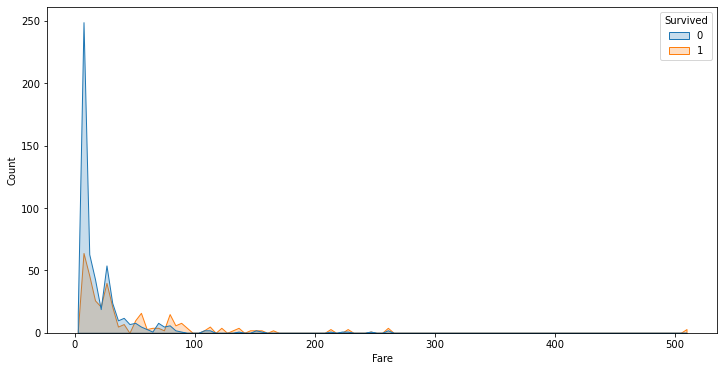

In [29]:
plt.figure(figsize=(12,6))
sns.histplot(x='Fare', hue='Survived', data=df_train_origin, element='poly')

## Cabin

**Hypothesis**

It seems hard to get insight from Cabin itself. However, Cabin might be related to Pclass and Fares.

<AxesSubplot:xlabel='Cabin', ylabel='count'>

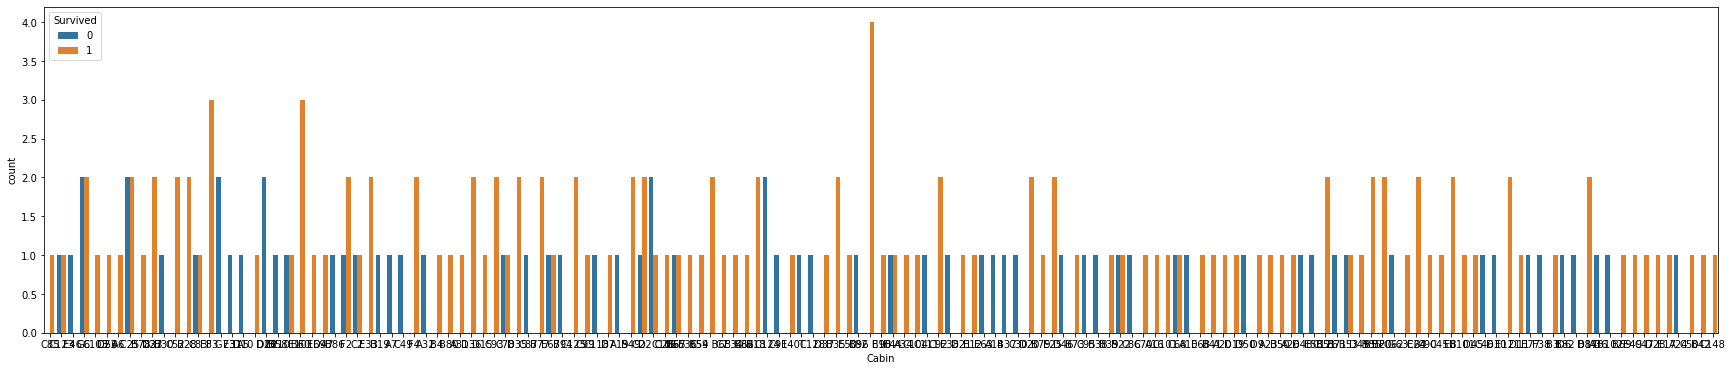

In [30]:
plt.figure(figsize=(30,6))
sns.countplot(x='Cabin', hue='Survived', data=df_train_origin)

## Embarked 

**Hypothesis**

Passengers who were on board at C are likely to survive.

In [31]:
pd.pivot_table(data=df_train_origin, values=['Survived'], index=['Embarked'], aggfunc=np.mean)

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


<AxesSubplot:xlabel='Embarked', ylabel='count'>

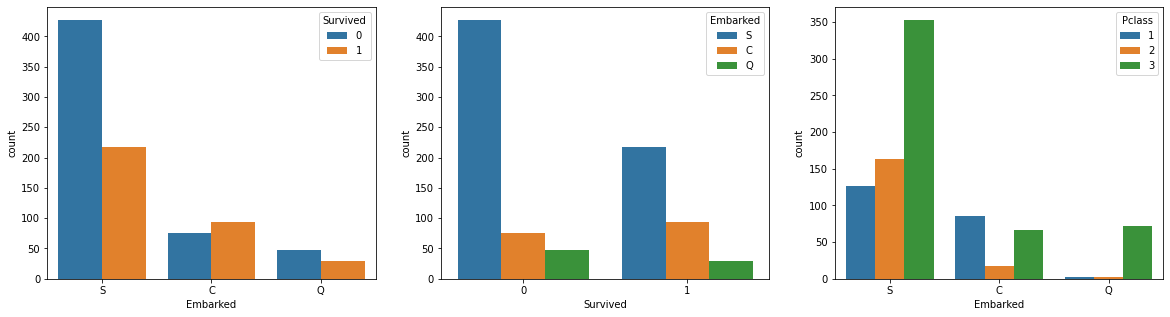

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.countplot(x='Embarked', hue='Survived', data=df_train_origin, ax=ax[0])
sns.countplot(x='Survived', hue='Embarked', data=df_train_origin, ax=ax[1])
sns.countplot(x='Embarked', hue='Pclass', data=df_train_origin, ax=ax[2])

## Name

**Hypothesis**

Passengers who have titles as Mrs, Miss, and Master are likely to survive. On the other hand, passengers who have title as Mr are unlikely to survive.

In [92]:
for i in range(len(df_train_origin)):
    #print(df_train.loc[df_train.index==i, 'Name'])
    #print(df_train.at[i, 'Name'].split(', ')[1].split('.')[0])
    df_train_origin.at[i, 'Title'] = df_train_origin.at[i, 'Name'].split(', ')[1].split('.')[0]

In [94]:
df_train_origin['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

Honorific Title in English: https://en.wikipedia.org/wiki/English_honorifics

Don: https://en.wikipedia.org/wiki/Don_(honorific)

Rev: https://en.wikipedia.org/wiki/The_Reverend

In [95]:
df_train_origin.loc[df_train_origin['Title'].isin(['Mr', 'Mrs', 'Miss', 'Master'])==False]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Title
30,31,0,1,"Uruchurtu, Don. Manuel E",male,40.0,0,0,PC 17601,27.7208,NaN,C,0,Don
149,150,0,2,"Byles, Rev. Thomas Roussel Davids",male,42.0,0,0,244310,13.0000,NaN,S,0,Rev
150,151,0,2,"Bateman, Rev. Robert James",male,51.0,0,0,S.O.P. 1166,12.5250,NaN,S,0,Rev
245,246,0,1,"Minahan, Dr. William Edward",male,44.0,2,0,19928,90.0000,C78,Q,2,Dr
249,250,0,2,"Carter, Rev. Ernest Courtenay",male,54.0,1,0,244252,26.0000,NaN,S,1,Rev
317,318,0,2,"Moraweck, Dr. Ernest",male,54.0,0,0,29011,14.0000,NaN,S,0,Dr
369,370,1,1,"Aubart, Mme. Leontine Pauline",female,24.0,0,0,PC 17477,69.3000,B35,C,0,Mme
398,399,0,2,"Pain, Dr. Alfred",male,23.0,0,0,244278,10.5000,NaN,S,0,Dr
443,444,1,2,"Reynaldo, Ms. Encarnacion",female,28.0,0,0,230434,13.0000,NaN,S,0,Ms
449,450,1,1,"Peuchen, Major. Arthur Godfrey",male,52.0,0,0,113786,30.5000,C104,S,0,Major


<AxesSubplot:xlabel='Survived', ylabel='count'>

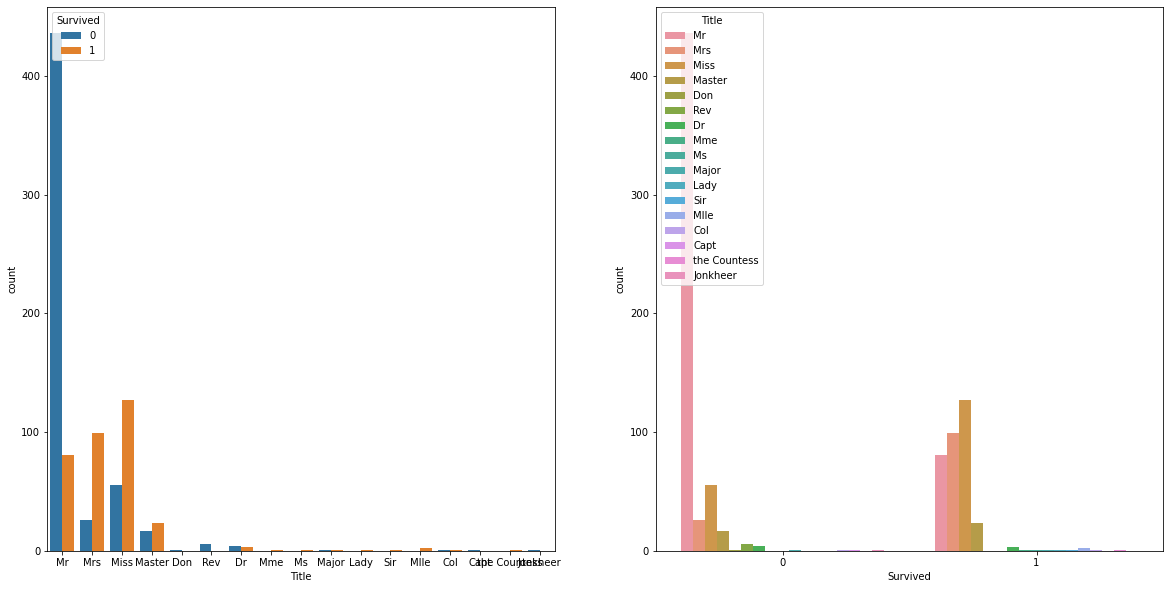

In [96]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
sns.countplot(data=df_train_origin, x='Title', hue='Survived', ax=ax[0])
sns.countplot(data=df_train_origin, x='Survived', hue='Title', ax=ax[1])

## Age & Fare

The more age is, the more fare is.

In [97]:
df_train_origin[['Age', 'Fare']].corr()

,Age,Fare
Age,1.000000,0.096067
Fare,0.096067,1.000000


<Figure size 864x432 with 0 Axes>

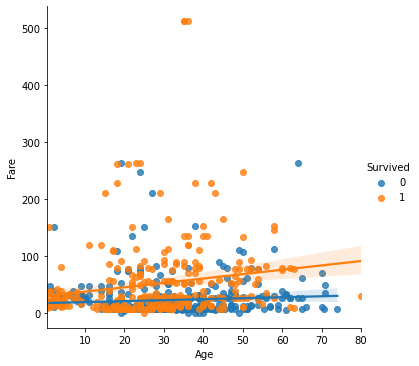

In [98]:
plt.figure(figsize=(12, 6))
sns.lmplot(x='Age', y='Fare', hue='Survived', data=df_train_origin)

## Pclass & Fare & Cabin

**Hypothesis**

The more passengers pay, the higher their Pclass are.

The correlation between Pclass and Cabin can not be calculated due to Cabin's data type(=object).

In [99]:
df_train_origin[['Pclass', 'Fare']].corr()

,Pclass,Fare
Pclass,1.0000,-0.5495
Fare,-0.5495,1.0000


<Figure size 864x432 with 0 Axes>

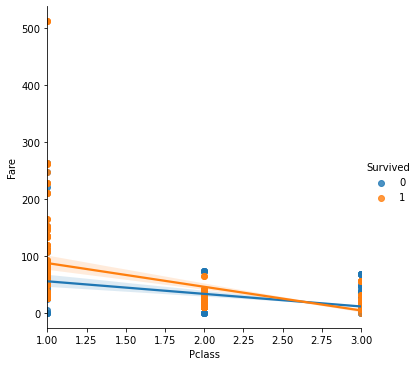

In [100]:
plt.figure(figsize=(12, 6))
sns.lmplot(x='Pclass', y='Fare', hue='Survived', data=df_train_origin)

In [101]:
df_train_origin[['Pclass', 'Cabin']].corr()

,Pclass
Pclass,1.0


# Conclusion(Temporary)

**Meaningful columns:**

Survived, Pclass, Sex, Age, SibSp, Parch, Fare, Embarked

In [87]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0,Rev
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,0,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,3,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0,Mr


In [21]:
# train.csv
df_train = df_train[['Survived', 'Pclass', 'Sex', 'Age', 'Family', 'Fare', 'Embarked', 'Cabin']]
print('-------------------------Train-------------------------')
display(df_train)

# test.csv
df_test = df_test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin']]
print('-------------------------Test-------------------------')
display(df_test)

-------------------------Train-------------------------


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin
0,0,3,male,22.0,1,0,7.2500,S,NaN
1,1,1,female,38.0,1,0,71.2833,C,C85
2,1,3,female,26.0,0,0,7.9250,S,NaN
3,1,1,female,35.0,1,0,53.1000,S,C123
4,0,3,male,35.0,0,0,8.0500,S,NaN
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,NaN
887,1,1,female,19.0,0,0,30.0000,S,B42
888,0,3,female,NaN,1,2,23.4500,S,NaN
889,1,1,male,26.0,0,0,30.0000,C,C148


-------------------------Test-------------------------


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin
0,3,male,34.5,0,0,7.8292,Q,NaN
1,3,female,47.0,1,0,7.0000,S,NaN
2,2,male,62.0,0,0,9.6875,Q,NaN
3,3,male,27.0,0,0,8.6625,S,NaN
4,3,female,22.0,1,1,12.2875,S,NaN
...,...,...,...,...,...,...,...,...
413,3,male,NaN,0,0,8.0500,S,NaN
414,1,female,39.0,0,0,108.9000,C,C105
415,3,male,38.5,0,0,7.2500,S,NaN
416,3,male,NaN,0,0,8.0500,S,NaN


# Preprocess Data

## Impute Missing Data

In [139]:
# Train Data
print('--------------------Train Data--------------------')
for col in df_train.columns:
    if df_train[col].isnull().values.any() == True:
        print('The number of missing values in '+col+' is {}'.format(df_train[col].isnull().sum()))
    else:
        print('No missing values in '+col)

print('\n--------------------Test Data--------------------')
# Test Data  
for col in df_test.columns:
    if df_test[col].isnull().values.any() == True:
        print('The number of missing values in '+col+' is {}'.format(df_test[col].isnull().sum()))
    else:
        print('No missing values in '+col)

--------------------Train Data--------------------
No missing values in PassengerId
No missing values in Survived
No missing values in Pclass
No missing values in Name
No missing values in Sex
The number of missing values in Age is 177
No missing values in SibSp
No missing values in Parch
No missing values in Ticket
No missing values in Fare
The number of missing values in Cabin is 687
The number of missing values in Embarked is 2

--------------------Test Data--------------------
No missing values in PassengerId
No missing values in Pclass
No missing values in Name
No missing values in Sex
The number of missing values in Age is 86
No missing values in SibSp
No missing values in Parch
No missing values in Ticket
The number of missing values in Fare is 1
The number of missing values in Cabin is 327
No missing values in Embarked


### Age

#### Round Age

In [260]:
# Train Data
#print('--------------------Train Data--------------------')
df_train.loc[df_train['Age'].notnull(), 'Age'] = np.array([round(age, 0) for age in df_train.loc[df_train['Age'].notnull(), 'Age'].values])
#print(df_train['Age'].unique())

# Test Data
#print('\n--------------------Test Data--------------------')
df_test.loc[df_test['Age'].notnull(), 'Age'] = np.array([round(age, 0) for age in df_test.loc[df_test['Age'].notnull(), 'Age'].values])
#print(df_test['Age'].unique())

#### 1. Using mean/median

In [261]:
# Train Data
print('--------------------Train Data--------------------')
# Average age of passengers who did survive
avg_age_survived = round(df_train.loc[(df_train['Age'].notnull()) & (df_train['Survived'] == 1), 'Age'].mean(), 0)
print('The average age of passengers who survived is {}'.format(avg_age_survived))

# Average age of passengers who did not survive
avg_age_no_survived = round(df_train.loc[(df_train['Age'].notnull()) & (df_train['Survived'] == 0), 'Age'].mean(), 0)
print('The average age of passengers who did not survive is {}'.format(avg_age_no_survived))

# Impute the missing values with the average ages
df_train.loc[(df_train['Age'].isnull()) & (df_train['Survived'] == 1), 'Age'] = avg_age_survived
df_train.loc[(df_train['Age'].isnull()) & (df_train['Survived'] == 0), 'Age'] = avg_age_no_survived


# Test Data
print('\n--------------------Test Data--------------------')
# Average age of passengers who did survive
avg_age = round(df_train.loc[(df_train['Age'].notnull()), 'Age'].mean(), 0)
print('The average age of passengers in train.csv {}'.format(avg_age))

# Impute the missing values with the average ages
df_test.loc[df_test['Age'].isnull(), 'Age'] = avg_age

--------------------Train Data--------------------
The average age of passengers who survived is 28.0
The average age of passengers who did not survive is 31.0

--------------------Test Data--------------------
The average age of passengers in train.csv 30.0


#### 2. K-NN

In [26]:
'''from sklearn.impute import KNNImputer

tmp = df_train[['Survived', 'Age']]
imputer_age = KNNImputer(n_neighbors=5)
tmp = pd.DataFrame(imputer_age.fit_transform(tmp), columns=['Survived', 'Age'])
tmp = round(tmp['Age'], 0)
df_train['Age'] = tmp
df_train['Age']'''

"from sklearn.impute import KNNImputer\n\ntmp = df_train[['Survived', 'Age']]\nimputer_age = KNNImputer(n_neighbors=5)\ntmp = pd.DataFrame(imputer_age.fit_transform(tmp), columns=['Survived', 'Age'])\ntmp = round(tmp['Age'], 0)\ndf_train['Age'] = tmp\ndf_train['Age']"

### Fare

#### 1. Using mean/median

In [262]:
# Test Data
# Average age of passengers who did survive
avg_fare = round(df_test.loc[(df_test['Fare'].notnull()), 'Fare'].mean(), 0)
print('The average fare of passengers in test.csv {}'.format(avg_fare))

# Impute the missing values with the average ages
df_test.loc[df_test['Fare'].isnull(), 'Fare'] = avg_fare

The average fare of passengers in test.csv 36.0


### Embarked

Only two passengers have a missing value in Embarked column. I dropped these two passengers off.

In [263]:
df_train.loc[df_train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [264]:
imp_frequent = SimpleImputer(strategy='most_frequent')

# Train Data
for i in df_train['Survived'].unique():
    for j in df_train['Pclass'].unique():        

        imp_frequent.fit(df_train.loc[(df_train['Survived']==i) &
                                      (df_train['Pclass']==j), ['Embarked']])

        df_train_cabin_imputed = imp_frequent.transform(df_train.loc[(df_train['Survived']==i) &
                                                                     (df_train['Pclass']==j), ['Embarked']])
        #print(df_train_cabin_imputed)
        #print(len(np.array(df_train_cabin_imputed[:,0])))

        df_train.loc[(df_train['Survived']==i) &
                     (df_train['Pclass']==j), 'Embarked'] = np.array(df_train_cabin_imputed[:,0])

### Cabin

I investigated data in Cabin column, and found a regularity in which cabin numbers consist of alphabet and numbers. I tried to categorize these cabin numbers into a few alphabatic code. However, it seems that Cabin is closely related to Pclass.

In [265]:
# Train Data
ls_cabin_train = df_train.loc[df_train['Cabin'].notnull(), 'Cabin'].values
df_train['Cabin_Sector'] = np.nan
df_train['Cabin_Number'] = np.nan

df_train.loc[df_train['Cabin'].notnull(), 'Cabin_Sector'] = [cabin_split[0] for cabin_split in [cabin.split(' ')[0] for cabin in ls_cabin_train]]
df_train.loc[df_train['Cabin'].notnull(), 'Cabin_Number'] = [cabin_split[1:] for cabin_split in [cabin.split(' ')[0] for cabin in ls_cabin_train]]

df_train.loc[(df_train['Cabin_Number'].notnull()) & (df_train['Cabin_Number']==''), 'Cabin_Number'] = np.nan
display(df_train)


# Test Data
ls_cabin_test = df_test.loc[df_test['Cabin'].notnull(), 'Cabin'].values
df_test['Cabin_Sector'] = np.nan
df_test['Cabin_Number'] = np.nan

df_test.loc[df_test['Cabin'].notnull(), 'Cabin_Sector'] = [cabin_split[0] for cabin_split in [cabin.split(' ')[0] for cabin in ls_cabin_test]]
df_test.loc[df_test['Cabin'].notnull(), 'Cabin_Number'] = [cabin_split[1:] for cabin_split in [cabin.split(' ')[0] for cabin in ls_cabin_test]]

df_test.loc[(df_test['Cabin_Number'].notnull()) & (df_test['Cabin_Number']==''), 'Cabin_Number'] = np.nan
display(df_test)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Sector,Cabin_Number
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,NaN,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,85
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,NaN,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,123
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,NaN,NaN
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,B,42
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,31.0,1,2,W./C. 6607,23.4500,NaN,S,NaN,NaN
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,C,148


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Sector,Cabin_Number
0,892,3,"Kelly, Mr. James",male,34.0,0,0,330911,7.8292,NaN,Q,NaN,NaN
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,NaN,NaN
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,NaN,NaN
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,NaN,NaN
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,30.0,0,0,A.5. 3236,8.0500,NaN,S,NaN,NaN
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,C,105
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.0,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,NaN,NaN
416,1308,3,"Ware, Mr. Frederick",male,30.0,0,0,359309,8.0500,NaN,S,NaN,NaN


#### 1. Most Frequent

Most missing values exist in a group of passengers who were in Pclass=3. Thus, the most frequent value came from a group of passengers in Pclass=1.

In [266]:
imp_frequent = SimpleImputer(strategy='most_frequent')

# Train Data
for i in df_train['Survived'].unique():
    for j in df_train['Pclass'].unique():        
        #print('--------------------'+'Survived=='+str(i)+' & Pclass=='+str(j)+'--------------------')

        imp_frequent.fit(df_train.loc[(df_train['Survived']==i) &
                                      (df_train['Pclass']==j), ['Cabin_Sector']])

        df_train_cabin_imputed = imp_frequent.transform(df_train.loc[(df_train['Survived']==i) &
                                                                     (df_train['Pclass']==j), ['Cabin_Sector']])
        #print(df_train_cabin_imputed)
        #print(len(np.array(df_train_cabin_imputed[:,0])))

        df_train.loc[(df_train['Survived']==i) &
                     (df_train['Pclass']==j), 'Cabin_Sector'] = np.array(df_train_cabin_imputed[:,0])

# Test Data
for i in df_test['Pclass'].unique():        
    #print('--------------------'+'Survived=='+str(i)+' & Pclass=='+str(j)+'--------------------')

    imp_frequent.fit(df_test.loc[(df_test['Pclass']==i), ['Cabin_Sector']])

    df_test_cabin_imputed = imp_frequent.transform(df_test.loc[(df_test['Pclass']==i), ['Cabin_Sector']])
    #print(df_train_cabin_imputed)
    #print(len(np.array(df_train_cabin_imputed[:,0])))

    df_test.loc[(df_test['Pclass']==i), 'Cabin_Sector'] = np.array(df_test_cabin_imputed[:,0])


imp_frequent = SimpleImputer(missing_values=np.nan, strategy='median')

# Train Data
for i in df_train['Survived'].unique():
    for j in df_train['Pclass'].unique(): 
        for t in df_train['Cabin_Sector'].unique():
            if len(df_train.loc[(df_train['Survived']==i) &
                                (df_train['Pclass']==j) &
                                (df_train['Cabin_Sector']==t), 'Cabin_Number']) != 0:
                
                if df_train.loc[(df_train['Survived']==i) &
                                (df_train['Pclass']==j) &
                                (df_train['Cabin_Sector']==t), 'Cabin_Number'].isnull().sum() != 0: # All rows have Nan
                    
                    df_train.loc[(df_train['Survived']==i) &
                                 (df_train['Pclass']==j) &
                                 (df_train['Cabin_Sector']==t), 'Cabin_Number'] = 0
                else:

                    imp_frequent.fit(df_train.loc[(df_train['Survived']==i) &
                                                  (df_train['Pclass']==j) &
                                                  (df_train['Cabin_Sector']==t), ['Cabin_Number']])

                    df_train_cabin_imputed = imp_frequent.transform(df_train.loc[(df_train['Survived']==i) &
                                                                                 (df_train['Pclass']==j) &
                                                                                 (df_train['Cabin_Sector']==t), ['Cabin_Number']])

                    #print(df_train_cabin_imputed)
                    #print(len(np.array(df_train_cabin_imputed[:,0])))

                    df_train.loc[(df_train['Survived']==i) &
                                 (df_train['Pclass']==j) &
                                 (df_train['Cabin_Sector']==t), 'Cabin_Number'] = np.array(df_train_cabin_imputed[:,0])

df_train['Cabin_Number'] = df_train['Cabin_Number'].astype('int64')

# Test Data
for i in df_test['Pclass'].unique(): 
    for j in df_test['Cabin_Sector'].unique():
        if len(df_test.loc[(df_test['Pclass']==i) &
                            (df_test['Cabin_Sector']==j), 'Cabin_Number']) != 0:
            
            if df_test.loc[(df_test['Pclass']==i) &
                            (df_test['Cabin_Sector']==j), 'Cabin_Number'].isnull().sum() != 0: # All rows have Nan
                
                df_test.loc[(df_test['Pclass']==i) &
                            (df_test['Cabin_Sector']==j), 'Cabin_Number'] = 0
            else:

                imp_frequent.fit(df_test.loc[(df_test['Pclass']==i) &
                                                (df_test['Cabin_Sector']==j), ['Cabin_Number']])

                df_test_cabin_imputed = imp_frequent.transform(df_test.loc[(df_test['Pclass']==i) &
                                                                                (df_test['Cabin_Sector']==j), ['Cabin_Number']])

                #print(df_test_cabin_imputed)
                #print(len(np.array(df_test_cabin_imputed[:,0])))

                df_test.loc[(df_test['Pclass']==i) &
                                (df_test['Cabin_Sector']==j), 'Cabin_Number'] = np.array(df_test_cabin_imputed[:,0])

df_test['Cabin_Number'] = df_test['Cabin_Number'].astype('int64')
 

## Check Imputation of Missing Values 

In [267]:
# Train Data
print('--------------------Train Data--------------------')
for col in df_train.columns:
    if df_train[col].isnull().values.any() == True:
        print('The number of missing values in '+col+' is {}'.format(df_train[col].isnull().sum()))
    else:
        print('No missing values in '+col)

print('\n--------------------Test Data--------------------')
# Test Data  
for col in df_test.columns:
    if df_test[col].isnull().values.any() == True:
        print('The number of missing values in '+col+' is {}'.format(df_test[col].isnull().sum()))
    else:
        print('No missing values in '+col)

--------------------Train Data--------------------
No missing values in PassengerId
No missing values in Survived
No missing values in Pclass
No missing values in Name
No missing values in Sex
No missing values in Age
No missing values in SibSp
No missing values in Parch
No missing values in Ticket
No missing values in Fare
The number of missing values in Cabin is 687
No missing values in Embarked
No missing values in Cabin_Sector
No missing values in Cabin_Number

--------------------Test Data--------------------
No missing values in PassengerId
No missing values in Pclass
No missing values in Name
No missing values in Sex
No missing values in Age
No missing values in SibSp
No missing values in Parch
No missing values in Ticket
No missing values in Fare
The number of missing values in Cabin is 327
No missing values in Embarked
No missing values in Cabin_Sector
No missing values in Cabin_Number


## Detect Outliers

In [ ]:
'''anomalies = []

dt_std = np.std(df_train['Age'])
print(dt_std)
dt_mean = np.mean(df_train['Age'])
print(dt_mean)
anomoly_cut_off = dt_std * 3

lower_limit = dt_mean - anomoly_cut_off
print(lower_limit)
upper_limit = dt_mean + anomoly_cut_off
print(upper_limit)

for outlier in df_train['Age']:
    if outlier > upper_limit or outlier < lower_limit:
        anomalies.append(outlier)
        
print(anomalies)'''

### Method: Standard Deviation

In [ ]:
'''#import random
#random.seed(1)

anomalies = []

dt_std = np.std(df_train['Age'])
print(dt_std)
dt_mean = np.mean(df_train['Age'])
print(dt_mean)
anomoly_cut_off = dt_std * 3

lower_limit = dt_mean - anomoly_cut_off
print(lower_limit)
upper_limit = dt_mean + anomoly_cut_off
print(upper_limit)

for outlier in df_train['Age']:
    if outlier > upper_limit or outlier < lower_limit:
        anomalies.append(outlier)
        
print(anomalies)'''

### Method: Boxplot

<AxesSubplot:xlabel='Age'>

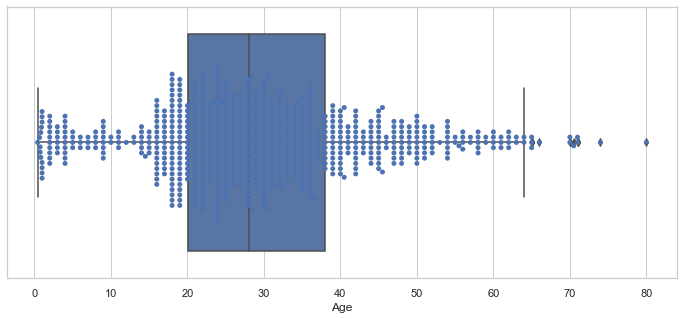

In [33]:
'''plt.figure(figsize=(12,5))
sns.set_theme(style='whitegrid')
sns.boxplot(x=df_train['Age'])
sns.swarmplot(x=df_train['Age'])'''

## Remove Outliers

In [81]:
'''df_train = df_train[df_train['Age']<70]
df_train'''

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,31.0,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


## Create Age Group

I followed the age grouping from the linke: https://www.statcan.gc.ca/eng/concepts/definitions/age2

In [377]:
bins = [-1, 14, 24, 64, np.inf]
groups = ['children', 'youth', 'adults', 'seniors']

# Train Data
df_train['Age_Group'] = pd.cut(df_train['Age'], bins, labels=groups, include_lowest=False)

# Test Data
df_test['Age_Group'] = pd.cut(df_test['Age'], bins, labels=groups, include_lowest=False)

## Create Family

**Hypothesis**

I combined two columns, SibSp and Parch, as a new column named Family because those two columns are similar concept.

Passengers who had one to three family members are likely to survive.

In [41]:
# Train Data
df_train['Family'] = df_train['SibSp'] + df_train['Parch']
df_train.drop(['SibSp', 'Parch'], axis=1, inplace=True)

# Test Data
df_test['Family'] = df_test['SibSp'] + df_test['Parch']
df_test.drop(['SibSp', 'Parch'], axis=1, inplace=True)

<AxesSubplot:xlabel='Family', ylabel='count'>

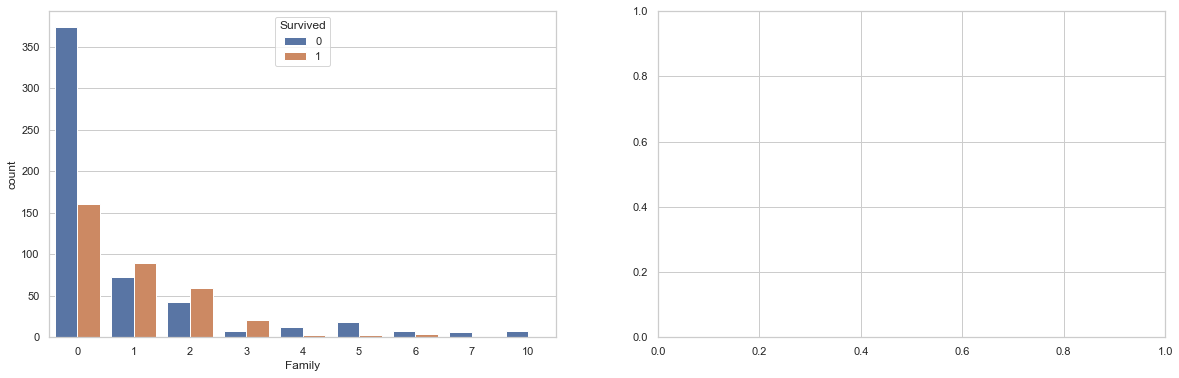

In [380]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.countplot(x='Family', hue='Survived', data=df_train, ax=ax[0])
#sns.countplot(x='Family', hue='Survived', data=df_test, ax=ax[1])

## Remove Outliers

In [82]:
anomalies = []

dt_std = np.std(df_train['Fare'])
dt_mean = np.mean(df_train['Fare'])
cut_off = dt_std * 3

lower_limit = dt_mean - cut_off
upper_limit = dt_mean + cut_off
print(upper_limit)

for outlier in df_train['Fare']:
    if outlier > upper_limit or outlier < lower_limit:
        anomalies.append(outlier)

anomalies.sort()
print(anomalies)

181.68716202644157
[211.3375, 211.3375, 211.3375, 211.5, 221.7792, 227.525, 227.525, 227.525, 227.525, 247.5208, 247.5208, 262.375, 262.375, 263.0, 263.0, 263.0, 263.0, 512.3292, 512.3292, 512.3292]


In [83]:
df_train = df_train[df_train['Fare']<211.3375]
df_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,31.0,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


## Encode Categorical Values 

In [381]:
# Train Data
df_train = pd.get_dummies(df_train, prefix=['Sex', 'Embarked', 'Age_Group', 'Cabin'], columns=['Sex', 'Embarked', 'Age_Group', 'Cabin'])
df_train.drop('Age', axis=1, inplace=True)

# Test Data
df_test = pd.get_dummies(df_test, prefix=['Sex', 'Embarked', 'Age_Group', 'Cabin'], columns=['Sex', 'Embarked', 'Age_Group', 'Cabin'])
df_test.drop('Age', axis=1, inplace=True)

In [382]:
df_train

,Survived,Pclass,Fare,Family,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Age_Group_children,Age_Group_youth,Age_Group_adults,Age_Group_seniors,Cabin_A,Cabin_B,Cabin_C
0,0,3,7.2500,1,0,1,0,0,1,0,1,0,0,0,0,1
1,1,1,71.2833,1,1,0,1,0,0,0,0,1,0,1,0,0
2,1,3,7.9250,0,1,0,0,0,1,0,0,1,0,0,0,1
3,1,1,53.1000,1,1,0,0,0,1,0,0,1,0,1,0,0
4,0,3,8.0500,0,0,1,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,13.0000,0,0,1,0,0,1,0,0,1,0,0,1,0
887,1,1,30.0000,0,1,0,0,0,1,0,1,0,0,1,0,0
888,0,3,23.4500,3,1,0,0,0,1,0,0,1,0,0,0,1
889,1,1,30.0000,0,0,1,1,0,0,0,0,1,0,1,0,0


In [384]:
df_test

,Pclass,Fare,Family,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Age_Group_children,Age_Group_youth,Age_Group_adults,Age_Group_seniors,Cabin_A,Cabin_B,Cabin_C
0,3,7.8292,0,0,1,0,1,0,0,0,1,0,0,0,1
1,3,7.0000,1,1,0,0,0,1,0,0,1,0,0,0,1
2,2,9.6875,0,0,1,0,1,0,0,0,1,0,0,1,0
3,3,8.6625,0,0,1,0,0,1,0,0,1,0,0,0,1
4,3,12.2875,2,1,0,0,0,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,8.0500,0,0,1,0,0,1,0,0,1,0,0,0,1
414,1,108.9000,0,1,0,1,0,0,0,0,1,0,1,0,0
415,3,7.2500,0,0,1,0,0,1,0,0,1,0,0,0,1
416,3,8.0500,0,0,1,0,0,1,0,0,1,0,0,0,1


## Scale Numberical Values

#### 1. Min-Max Scaling

#### 2. Standardization

In [90]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 862 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    862 non-null    int64  
 1   Pclass      862 non-null    int64  
 2   Age         862 non-null    float64
 3   Fare        862 non-null    float64
 4   Sex_female  862 non-null    uint8  
 5   Sex_male    862 non-null    uint8  
 6   Embarked_C  862 non-null    uint8  
 7   Embarked_Q  862 non-null    uint8  
 8   Embarked_S  862 non-null    uint8  
 9   Family      862 non-null    int64  
dtypes: float64(2), int64(3), uint8(5)
memory usage: 76.9 KB


# Split Data into Train & Test

In [385]:
'''features = df_train.drop('Survived', axis=1)
label = df_train['Survived']

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=.2, random_state=42)'''

# training data
X_train = df_train.drop('Survived', axis=1)
y_train = df_train['Survived']

# test data
X_test = df_test

# Compare Models

In [103]:
models_classification = [
    SVC(random_state=42),
    SGDClassifier(random_state=42),
    KNeighborsClassifier(),
    GaussianProcessClassifier(random_state=42),
    GaussianNB(),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42)
]

In [100]:
eval_clf = {}

for model in models_classification:

    model_name = str(model).split('(')[0]
    
    #model_clf = model(hyper_params)
    
    # Train
    model.fit(X_train, y_train)
    
    # Test
    y_pred = model.predict(X_test)
    
    # Evaluate
    eval_clf[model_name] = f1_score(y_test, y_pred)

Text(0.5, 1.0, 'Comparison of Classification Models')

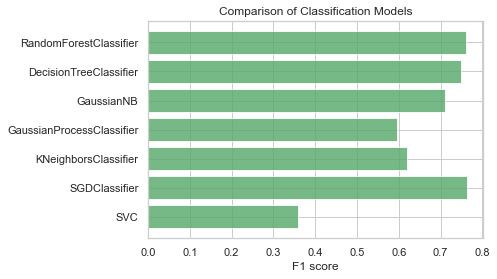

In [101]:
# F1 score results
fig, ax = plt.subplots()
idx = range(len(eval_clf))
ax.barh(idx, list(eval_clf.values()), align='center', color='#55a868', alpha=0.8)
ax.set_yticks(idx)
ax.set_yticklabels(eval_clf.keys())
ax.set_xlabel('F1 score')
ax.tick_params(left=False, top=False, right=False) 
ax.set_title('Comparison of Classification Models')
#fig.savefig('images/compare_models.png', bbox_inches = 'tight')

# Conclusion(Temorary)

RandomForestClassifier and SGDClassifier models seem to perform well.

# Build Model 

In [159]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [386]:
hyper_params = {
    #'bootstrap': True,
    #'ccp_alpha': 0.0,
    #'class_weight': None,
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    #'max_leaf_nodes': None,
    #'max_samples': None,
    #'min_impurity_decrease': 0.0,
    #'min_impurity_split': None,
    'min_samples_leaf': [1, 2, 3, 5, 10],
    'min_samples_split': [2, 3, 4, 5, 10, 50],
    #'min_weight_fraction_leaf': 0.0,
    'n_estimators': [50, 100, 200, 300, 500, 1000],
    #'n_jobs': -1,
    #'oob_score': False,
    #'random_state': 42,
    #'verbose': 0,
    #'warm_start': False
}

In [387]:
model_clf = RandomForestClassifier()
gs = GridSearchCV(model_clf, hyper_params)

In [388]:
gs.fit(X_train, y_train)
gs.best_params_

{'criterion': 'entropy',
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 50}

In [390]:
model_clf = RandomForestClassifier(
    criterion='entropy',
    max_depth=50,
    max_features='sqrt',
    min_samples_leaf=3,
    min_samples_split=5,
    n_estimators=50
)

model_clf.fit(X_train, y_train)
prediction = model_clf.predict(X_test)

In [ ]:
submission = pd.read_csv('titanic/gender_submission.csv', index_col="PassengerId")
submission['Survived'] = prediction
submission.to_csv('titanic/random_forest_classifier.csv')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/jk/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-391-de5fac215b0d>", line 1, in <module>
    submission = pd.read_csv('Google Drive/My Drive/Data Science/Kaggle/Titanic - Machine Learning from Disaster/gender_submission.csv', index_col="PassengerId")
  File "/Users/jk/opt/anaconda3/lib/python3.8/site-packages/pandas/io/parsers.py", line 610, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/Users/jk/opt/anaconda3/lib/python3.8/site-packages/pandas/io/parsers.py", line 462, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/Users/jk/opt/anaconda3/lib/python3.8/site-packages/pandas/io/parsers.py", line 819, in __init__
    self._engine = self._make_engine(self.engine)
  File "/Users/jk/opt/anaconda3/lib/python3.8/site-packages/pandas/io/parsers.py", line 1050, in _make_engi